In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

# better quality visualizations
# %config InlineBackend.figure_format = "retina"

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
device

'cuda'

In [15]:
# desired size of the output image
imsize = (192, 256) # use small size if no GPU

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor(),  # transform it into a torch tensor
    transforms.Normalize(cnn_normalization_mean, cnn_normalization_std)
])  


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [16]:
style_img = image_loader('style-transfer-photos/vangogh-starry-night.jpg')
content_img = image_loader('style-transfer-photos/neckarfront.jpg')

style_img.shape, content_img.shape

(torch.Size([1, 3, 192, 256]), torch.Size([1, 3, 192, 256]))

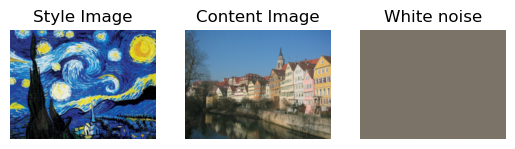

In [17]:
unloader = transforms.Compose([
    transforms.Normalize(-cnn_normalization_mean/cnn_normalization_std, 1/cnn_normalization_std),
    transforms.ToPILImage(), 
])  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    # display(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.imshow(image)
    

noise_img = torch.randn(content_img.shape, device=device, dtype=torch.float) / 1e2

plt.subplot(1, 3, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 3, 2)
imshow(content_img, title='Content Image')

plt.subplot(1, 3, 3)
imshow(noise_img, title='White noise')

In [18]:
class ContentLoss(nn.Module):
    def __init__(self, content_response, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # content is the original content image
        # its response to the filters
        self.content_response = content_response.detach()
        
    def forward(self, img_response):
        # img is like the white noise being GDed to match the response generated by the content image
        # img_response is response which it generated by the filters
        self.loss = F.mse_loss(img_response, self.content_response)
        return img_response
    
class StyleLoss(nn.Module):
    # E_l in the paper
    def __init__(self, style_response, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.style_response_gram = self.gram_matrix(style_response.detach())
        
    @staticmethod
    def gram_matrix(filter_responses):
        b, c, h, w = filter_responses.size()
        features = filter_responses.view(b * c, h * w)
        
        return torch.mm(features, features.t()).div(b*c*h*w)
        
    def forward(self, img_response):
        self.loss = F.mse_loss(self.gram_matrix(img_response), self.style_response_gram)
        return img_response
    
class TVLoss(nn.Module):
    """
    Calculate total variation Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, input):
        self.x_diff = input[:,:,1:,:] - input[:,:,:-1,:]
        self.y_diff = input[:,:,:,1:] - input[:,:,:,:-1]
        self.loss = (torch.sum(torch.abs(self.x_diff)) + torch.sum(torch.abs(self.y_diff)))
        return input

In [19]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [20]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4_2']
style_layers_default = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']

def get_model_and_losses(cnn, content_img, style_img, content_layers=content_layers_default, style_layers=style_layers_default):
    model = nn.Sequential()
    
    i = 1
    l = 1
    
    content_losses = []
    style_losses = []
    tv_losses = []
    
    for layer in cnn.children():
        
        if isinstance(layer, nn.Conv2d):
            name = f'conv_{l}_{i}'
        
        elif isinstance(layer, nn.ReLU):
            # increment conv layer in same block
            i += 1
            name = f'relu_{l}_{i}'
            layer = nn.ReLU(inplace=False)
            
        elif isinstance(layer, nn.MaxPool2d):
            # layer module changes after pooling layer
            l += 1
            i = 1
            name = f'pool_{l}'
            layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
            
        else:
            raise RuntimeError('layer not recognised')
        
        model.add_module(name, layer)
        
        if name in content_layers:
            # ??? we obtain the response only from 1 layer for content ???
            content_response = model(content_img).detach()
            content_loss = ContentLoss(content_response)
            model.add_module(f'content_loss_{l}_{i}', content_loss)
            content_losses.append(content_loss)
            tv_loss = TVLoss()
            model.add_module(f'tv_loss_{l}_{i}', tv_loss)
            tv_losses.append(tv_loss)
        
        if name in style_layers:
            # for style we get representation from the whole subset of the model till this layer
            style_response = model(style_img).detach()
            style_loss = StyleLoss(style_response)
            model.add_module(f'style_loss_{l}_{i}', style_loss)
            style_losses.append(style_loss)
            tv_loss = TVLoss()
            model.add_module(f'tv_loss_{l}_{i}', tv_loss)
            tv_losses.append(tv_loss)
            
    return model.to(device), content_losses, style_losses, tv_losses

In [24]:
def run_style_transfer(input_img, content_img, style_img, style_weight=1e6, content_weight=1, tv_weight=1e-10, num_steps=200):
    model, content_losses, style_losses, tv_losses = get_model_and_losses(cnn, content_img, style_img)
    model.eval()
    model.requires_grad_(False)
    
    input_img = input_img.clone()
    input_img.requires_grad_(True)
    optimizer = optim.LBFGS(params=[input_img], line_search_fn='strong_wolfe')
    i = 0
    while i < num_steps:
    
        def closure():
            with torch.no_grad():
                input_img.clamp_(-2, 2)
            optimizer.zero_grad()
            
            _ = model(input_img)
            
            style_score = 0
            content_score = 0
            tv_score = 0
            for sl in style_losses:
                style_score += sl.loss
            
            for cl in content_losses:
                content_score += cl.loss
                
            for tl in tv_losses:
                tv_score += tl.loss
                
            style_score *= style_weight  
            content_score *= content_weight
            tv_score *= tv_weight
                
            loss = style_score + content_score
                
            loss.backward()  
            nonlocal i
            if i%50 == 0:
                print(f'Step {i}: Style loss {style_score.item():.3f}, Content loss {content_score.item():.3f}, TV loss {tv_score.item():.3f}')                
                imshow(input_img.detach())
                plt.show()
                
            i+=1                
            return style_score + content_score
    
        optimizer.step(closure)
    
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(-2, 2)
    
    return input_img.detach()

Step 0: Style loss 16607.812, Content loss 713.447, TV loss 0.457


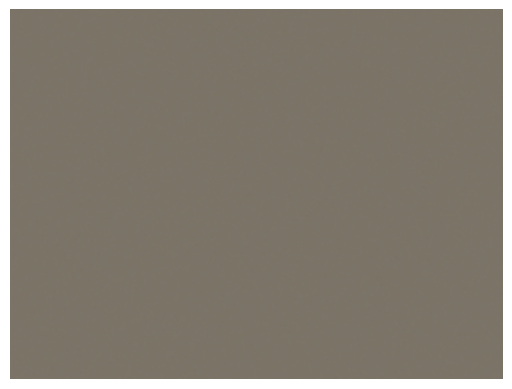

Step 50: Style loss 274.185, Content loss 382.995, TV loss 15.769


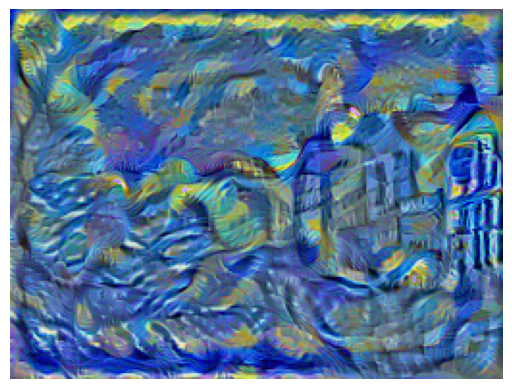

Step 100: Style loss 138.004, Content loss 234.710, TV loss 15.644


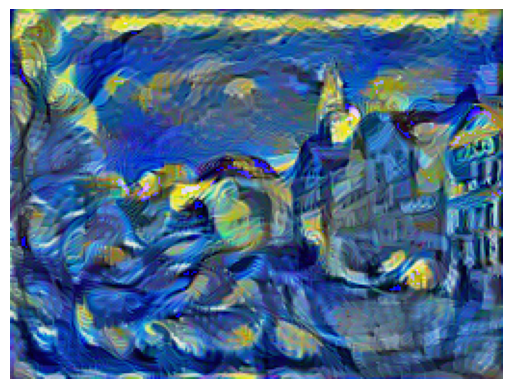

Step 150: Style loss 111.281, Content loss 193.161, TV loss 15.596


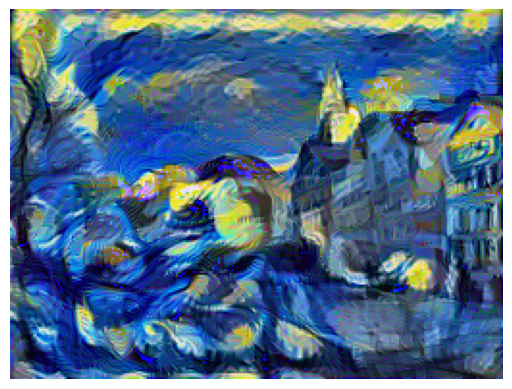

Step 200: Style loss 105.425, Content loss 188.817, TV loss 15.660


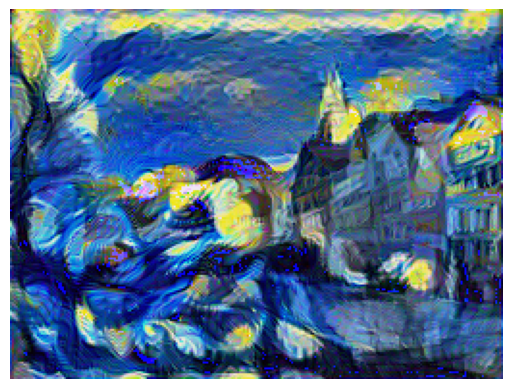

Step 250: Style loss 107.875, Content loss 187.697, TV loss 15.710


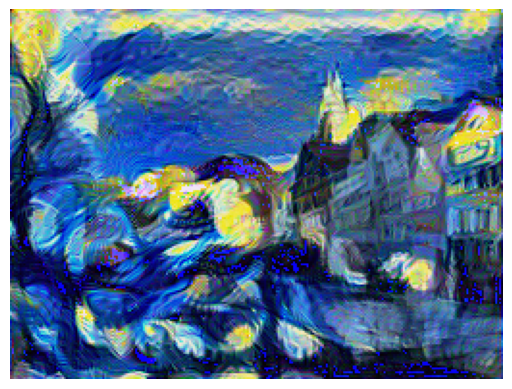

Step 300: Style loss 98.553, Content loss 176.966, TV loss 15.649


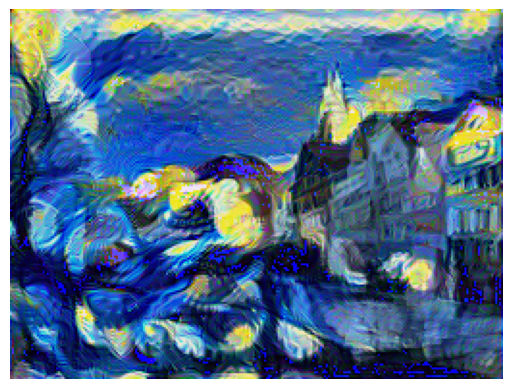

Step 350: Style loss 106.096, Content loss 181.582, TV loss 15.700


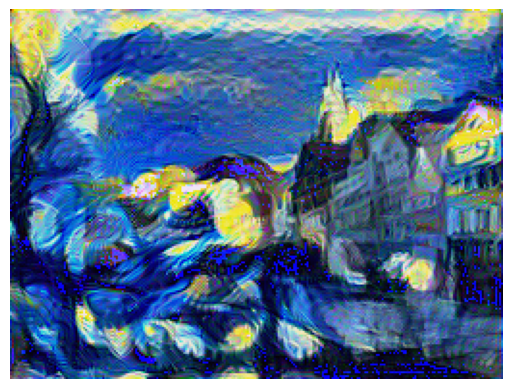

Step 400: Style loss 98.110, Content loss 173.359, TV loss 15.681


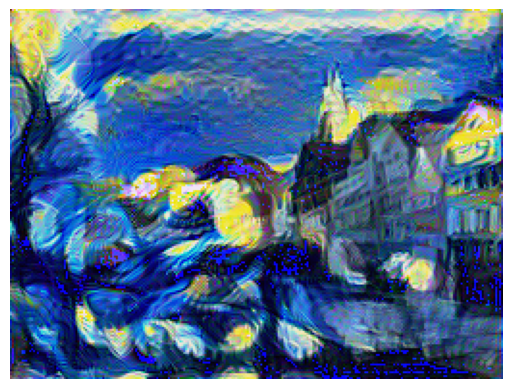

Step 450: Style loss 98.110, Content loss 173.359, TV loss 15.681


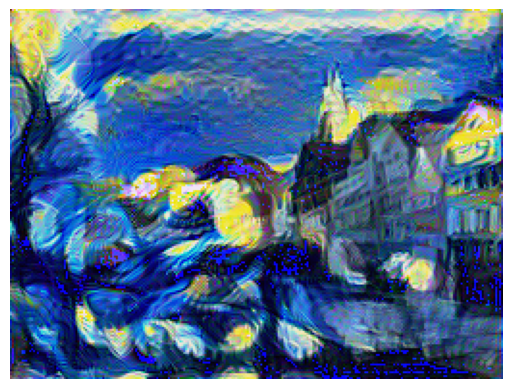

Step 500: Style loss 98.110, Content loss 173.359, TV loss 15.681


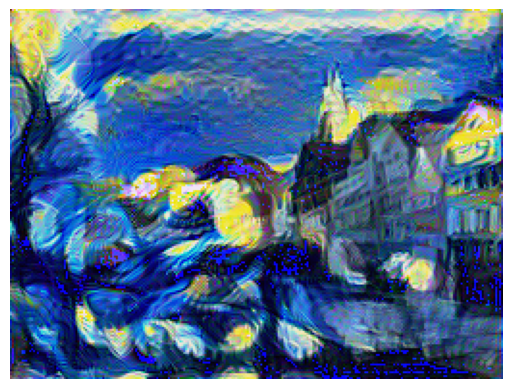

Step 550: Style loss 98.110, Content loss 173.359, TV loss 15.681


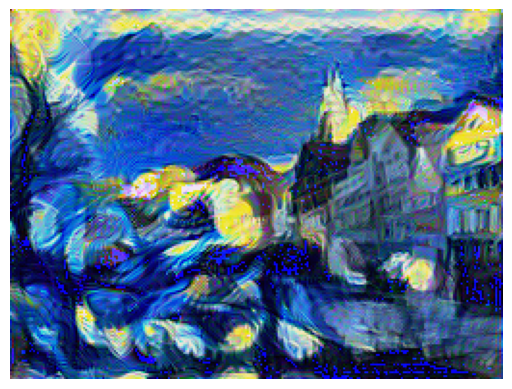

Step 600: Style loss 98.110, Content loss 173.359, TV loss 15.681


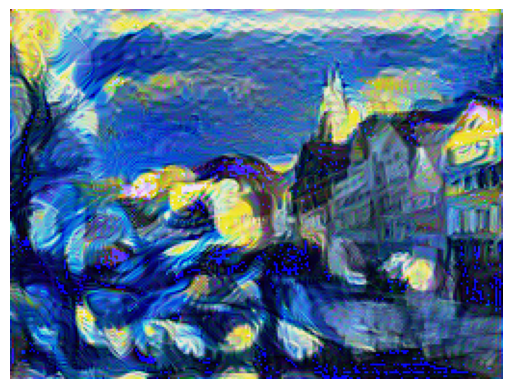

In [26]:
output_img = run_style_transfer(noise_img, content_img, style_img, style_weight=1e7, content_weight=1e2, tv_weight=1e-6, num_steps=600)

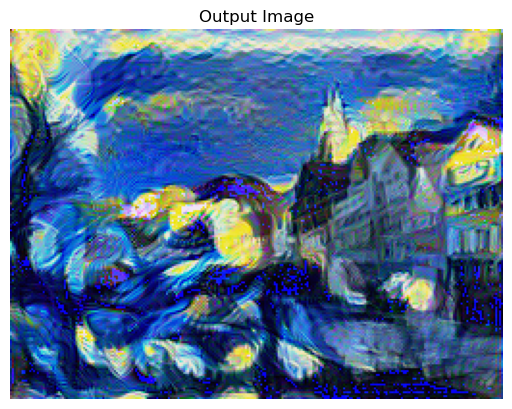

In [27]:
imshow(output_img, title='Output Image')
plt.show()